In [1]:
!pip install albumentations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
from torch.utils.data import RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from collections import defaultdict
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Compose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomGamma
)

from metrics import dice
from data import NeuronSegmDataset

from torch import nn
import torch

from encoders import ResNetEncoders
from unet import UNet

def tonp(t):
    return t.detach().cpu().numpy()
    
def process_batch(b):
    X, y  = b
    X = X.to(DEVICE)
    y = torch.tensor(y, dtype=torch.float).to(DEVICE)
    return X, y

def prediction_to_numpy(pred):
    return pred.sigmoid().detach().cpu().numpy() 

def evaluate(model, loader, threshold):
    model = model.eval()
    for b in loader:
        X, y = process_batch(b)
        res = model(X)
    val_loss = nn.BCEWithLogitsLoss()(res, y)
    pred_Y, real_Y = prediction_to_numpy(res) > threshold, tonp(y)> threshold
    dices = []
    for ypred, yreal in zip(pred_Y, real_Y):
        dices.append(dice(ypred, yreal))
    return np.array(dices).mean(), val_loss.detach().cpu().numpy()




You are using pip version 18.0, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Create a Fully Connected Segmentation Architecture 
This means it will work similary to any other CONV architecture, in the end it will map the dense layer into a 1,192,192 shape

In [140]:
def create_conv(in_ft, out_ft):
    conv = nn.Sequential(
            nn.Conv2d(in_ft, out_ft, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ft),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
    
    return conv



class SSN(nn.Module):
    def __init__(self):
        super(SSN, self).__init__()

        
        # Create 4 conv layers with 16, 32, 64, 16 output features
        # Create a Linear layer that will map this into a 192x192 vector
        # Assume input shape to be (1, 1, 192, 192)
        
        
        self.linear = ????

        
    def forward(self, x):
        after_conv = ???
        flatten = ???

        lin = self.linear(flatten)
        
        # forward image trought the network, remember to reshape accordingly we want to see (BS, 1, 192, 192)
    
        return lin.view(xs.shape[0],1,192,192)
        

SyntaxError: invalid syntax (<ipython-input-140-73f4eeccf5cd>, line 23)

### Create a Unet-Like architecture this means a network that will have the pooling path, upsampling and lateral connections.

In [ ]:

class AlaUnet(nn.Module):
    def __init__(self):
        super(AlaUnet, self).__init__()
        ???
  
        
    def forward(self, x):
        ????
        
        return x

In [14]:
neuron_target = './train-labels.tif'
neuron_train = './train-volume.tif'


trans_train = transforms.Compose([transforms.Resize(192), 
                                  transforms.ToTensor()])
trans_test = transforms.Compose([transforms.Resize(192), 
                                 transforms.ToTensor()])

aug = Compose([
#     RandomGamma(), 
               VerticalFlip(), 
#                HorizontalFlip(),
#                RandomRotate90(), 
#                GridDistortion(),
#                ElasticTransform(),
#                OpticalDistortion(distort_limit=1, shift_limit=1)
])


train_ds = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_train, augmenter=aug)
test_ds = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_test)
train_ds_val = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_train)


random_training_sampler = RandomSampler(train_ds)
train_idx , test_idx = train_test_split(range(len(train_ds)), test_size=0.15)

random_sampler_train = RandomSampler(train_idx)
sampler_test = SequentialSampler(test_idx)

training_data_loader = DataLoader(train_ds, batch_size=1, num_workers=1, sampler=random_training_sampler)
test_data_loader = DataLoader(test_ds, batch_size=6, num_workers=1, sampler=sampler_test)
train_ds_val_loader = DataLoader(train_ds_val, batch_size=6, num_workers=1, sampler=random_training_sampler)


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = AlaUnet().to(DEVICE)
model = SSN().to(DEVICE)

optim = torch.optim.Adam(model.parameters())
epochs = 1000
loss_bce = nn.BCEWithLogitsLoss()
loss = 0
THRESHOLD = 0.5
history = defaultdict(list)

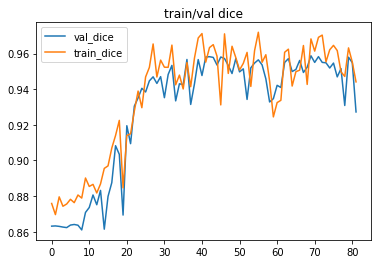

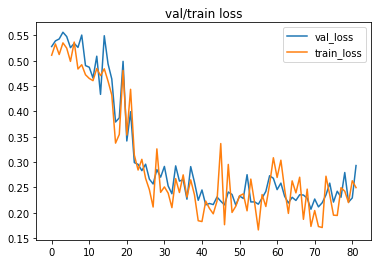

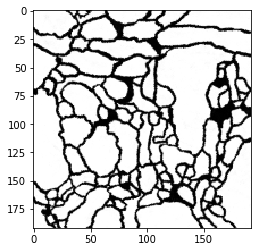

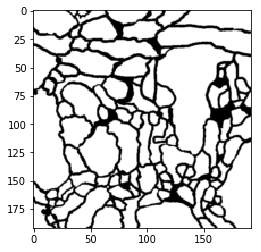

In [17]:
epochs=200

for i, _ in enumerate(range(epochs)):
    for batch in training_data_loader:
        X, y = process_batch(batch)
        prediction = model(X)  # [N, 2, H, W]
        loss = loss_bce(prediction, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()   
        
    val_mean_dice, val_loss = evaluate(model, test_data_loader, threshold=THRESHOLD)
    train_mean_dice, train_loss = evaluate(model, train_ds_val_loader, threshold=THRESHOLD)
    
    print("epoch", i)
    print('dice', val_mean_dice)
    print('loss', val_loss)
    print('train_dice', train_mean_dice)
    print('train_loss', train_loss)
    model.train()
    
    history['val_dice'].append(val_mean_dice)
    history['val_loss'].append(val_loss)
    history['train_dice'].append(train_mean_dice)
    history['train_loss'].append(train_loss)
    
    

df = pd.DataFrame(history)

plt.figure()
plt.title('train/val dice')
plt.plot(df.val_dice)
plt.plot(df.train_dice)
plt.legend(['val_dice', 'train_dice'])
plt.figure()
plt.title('val/train loss')
plt.plot(df.val_loss)
plt.plot(df.train_loss)
plt.legend(['val_loss', 'train_loss'])


plt.figure()
plt.imshow(prediction[0][0].detach().sigmoid().cpu().numpy(), cmap='gray')
plt.figure()
plt.imshow(y.detach()[0][0].cpu().numpy(), cmap='gray')


In [172]:
%%writefile .alaunet.py

class AlaUnet(nn.Module):
    def __init__(self):
        super(AlaUnet, self).__init__()

        
        # Create 4 conv layers with 16, 32, 64, 16 inputs
        # Create a Linear layer that will map this into a 192x192 vector
        # Assume input shape to be (1, 1, 192, 192)
        
        
        self.layer0 = nn.Sequential(nn.Conv2d(1, 4, kernel_size=3, padding=1))
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        self.upsample = nn.Upsample(scale_factor=2)
        
        self.layer1_up_stream = nn.Sequential(nn.Conv2d(48, 16, kernel_size=1), nn.ReLU())  
        self.layer2_up_stream = nn.Sequential(nn.Conv2d(24, 20, kernel_size=1), nn.ReLU())
        self.layer3_up_stream = nn.Sequential(nn.Conv2d(24, 16, kernel_size=1), nn.ReLU())
        self.layer4_up_stream = nn.Sequential(nn.Conv2d(17, 1, kernel_size=1), nn.ReLU())

        
        
    def forward(self, x):
        down0 = self.layer0(x)
        down1 = self.layer1(down0)
        down2 = self.layer2(down1)
        down3 = self.layer3(down2)
        down4 = self.layer4(down3)
        
        up1 = self.upsample(down4)
        
        first_up = torch.cat([up1, down3], dim=1)
        up2 = self.upsample(self.layer1_up_stream(first_up))
        
        second_up = torch.cat([up2, down2], dim=1)
        up3 = self.upsample(self.layer2_up_stream(second_up))
        
        third_up = torch.cat([up3, down1],dim=1)
        up4 = self.upsample(self.layer3_up_stream(third_up))
        
        
        x = self.layer4_up_stream(torch.cat([x, up4], dim=1))
        
        
        return x
                


Overwriting .alaunet.py


In [18]:
%%writefile .ssn.py

class SSN(nn.Module):
    def __init__(self):
        super(SSN, self).__init__()

        
        # Create 4 conv layers with 16, 32, 64, 16 inputs
        # Create a Linear layer that will map this into a 192x192 vector
        # Assume input shape to be (1, 1, 192, 192)
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        self.linear = nn.Linear(1 * 12 * 12, 36864)

        
    def forward(self, x):
        after_conv =self.layer4(self.layer3(self.layer2(self.layer1(x))))
        flatten = after_conv.view(after_conv.shape[0], -1)

        lin = self.linear(flatten)
        
    
        return lin.view(x.shape[0],1,192,192)

Overwriting .ssn.py


In [4]:
from torchsummary.torchsummary import summary

In [12]:
s=SSN()

summary(s.to('cuda'), (1,192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 192, 192]             160
       BatchNorm2d-2         [-1, 16, 192, 192]              32
              ReLU-3         [-1, 16, 192, 192]               0
         MaxPool2d-4           [-1, 16, 96, 96]               0
            Conv2d-5           [-1, 32, 96, 96]           4,640
       BatchNorm2d-6           [-1, 32, 96, 96]              64
              ReLU-7           [-1, 32, 96, 96]               0
         MaxPool2d-8           [-1, 32, 48, 48]               0
            Conv2d-9           [-1, 64, 48, 48]          18,496
      BatchNorm2d-10           [-1, 64, 48, 48]             128
             ReLU-11           [-1, 64, 48, 48]               0
        MaxPool2d-12           [-1, 64, 24, 24]               0
           Conv2d-13            [-1, 1, 24, 24]             577
             ReLU-14            [-1, 1,

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo
from torchvision import models
import math

class GCN(nn.Module):
    def __init__(self,c,out_c,k=7): #out_Channel=21 in paper
        super(GCN, self).__init__()
        self.conv_l1 = nn.Conv2d(c, out_c, kernel_size=(k,1), padding =(int((k-1)/2),0))
        self.conv_l2 = nn.Conv2d(out_c, out_c, kernel_size=(1,k), padding =(0, int((k-1)/2)))
        self.conv_r1 = nn.Conv2d(c, out_c, kernel_size=(1,k), padding =(int((k-1)/2),0))
        self.conv_r2 = nn.Conv2d(out_c, out_c, kernel_size=(k,1), padding =(0,int((k-1)/2)))
#         
    def forward(self, x):
        x_l = self.conv_l1(x)
        x_l = self.conv_l2(x_l)
        
        x_r = self.conv_r1(x)
        x_r = self.conv_r2(x_r)
        
        x = x_l + x_r
        
        return x

In [60]:
n = GCN(16, 16)

In [61]:
k = torch.randn((1, 16, 64, 64))

In [42]:
k = 7
# (k-1)/2,0

In [46]:
(0, int((k-1)/2))

(0, 3)

In [50]:
(int((k-1)/2),0)

(3, 0)

In [63]:
n(k).shape

torch.Size([1, 16, 64, 64])

In [65]:
n.conv_l1(k).shape

torch.Size([1, 16, 64, 64])

In [66]:
k.shape

torch.Size([1, 16, 64, 64])